In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import sklearn
import glob

In [2]:
class AEDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.images = [f for f in os.listdir(self.data_dir) \
         if os.path.isfile(os.path.join(self.data_dir, f))]
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.images[idx])
        img = cv2.imread(img_name)
        sample = {'in': img, 'out': img}
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return len(self.images)
    
    
class ToTensor(object):
    
    def __call__(self, sample):
        in_img, out_img = sample['in'], sample['out']
        in_img = np.transpose(in_img, (2, 0, 1))
        out_img = np.transpose(out_img, (2, 0, 1))

        return {'in': torch.from_numpy(in_img).float(),
                'out': torch.from_numpy(out_img).float()}

class Resize(object):
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        in_img, out_img = sample['in'], sample['out']
        in_img = cv2.resize(in_img, dsize=(self.size,self.size), interpolation=cv2.INTER_CUBIC)
        out_img = cv2.resize(out_img, dsize=(self.size,self.size), interpolation=cv2.INTER_CUBIC)
        
        return {'in':in_img, 'out':out_img}

In [3]:
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, 2)
        self.conv2 = nn.Conv2d(6, 9, 7, 2)
        self.encoding = nn.Linear(9*4*4,4)
        self.decoding = nn.Linear(4,9*4*4)
        self.deconv1 = nn.ConvTranspose2d(9, 6, 7, 2, 0, 1)
        self.deconv2 = nn.ConvTranspose2d(6, 3, 7, 2, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,9*4*4)
        y = self.encoding(x)
        x = self.decoding(y)
        x = x.view(-1,9,4,4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))

        return x, y

In [29]:
epochs = 10
batch_size = 128
lr = 1e-3

data_dir = "CycleGAN/autonomous-driving-unpaired-sim-real-dataset/"
datasets = glob.glob(data_dir+'*/')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using:', device)

if use_cuda:
    torch.cuda.empty_cache()

trns = transforms.Compose([Resize(32), ToTensor()])
ae = AE().to(device).train()

optimizer = optim.Adam(ae.parameters(), lr=lr, betas=(0.5, 0.999))

L1 = nn.L1Loss().to(device)
loss_ae = 0

for data in datasets:
    print('\nDataset --> {}'.format(data.split("\\")[-2]))
    dataset = AEDataset(data, transform=trns)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for idx, sample in enumerate(data_loader):
            in_img = sample['in'].to(device)
            out_img = sample['out'].to(device)
            optimizer.zero_grad()
            pred_out,latent_space = ae(in_img)
            loss = L1(pred_out, out_img)
            loss.backward()
            optimizer.step()
            loss_ae += loss.item()
        loss_ae = loss_ae/idx
        print('Epoch: {}'.format(epoch+1))
        print('AE Loss: {}'.format(loss_ae))
        loss_ae = 0

Using: cuda

Dataset --> Cityscapes
Epoch: 1
AE Loss: 50.983207115760216
Epoch: 2
AE Loss: 37.20234396518805
Epoch: 3
AE Loss: 35.03435535919972
Epoch: 4
AE Loss: 34.00778031960512
Epoch: 5
AE Loss: 33.60166388291579
Epoch: 6
AE Loss: 33.245150394928764
Epoch: 7
AE Loss: 32.89677101526505
Epoch: 8
AE Loss: 32.65287438417092
Epoch: 9
AE Loss: 32.25544963738857
Epoch: 10
AE Loss: 31.93491074977777

Dataset --> KITTI
Epoch: 1
AE Loss: 56.61474675145642
Epoch: 2
AE Loss: 55.09499188127189
Epoch: 3
AE Loss: 54.22592255164837
Epoch: 4
AE Loss: 53.58335008292362
Epoch: 5
AE Loss: 53.09998005834119
Epoch: 6
AE Loss: 52.560314704631935
Epoch: 7
AE Loss: 52.31735571499529
Epoch: 8
AE Loss: 52.12239219402445
Epoch: 9
AE Loss: 51.858623899262525
Epoch: 10
AE Loss: 51.71681029221107

Dataset --> Synthia
Epoch: 1
AE Loss: 39.78323731055627
Epoch: 2
AE Loss: 37.45726732107309
Epoch: 3
AE Loss: 37.2492910531851
Epoch: 4
AE Loss: 37.07599889315092
Epoch: 5
AE Loss: 36.85172235048734
Epoch: 6
AE Loss: 3

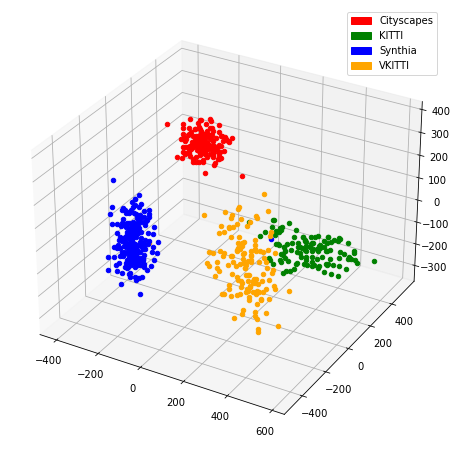

In [30]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

dataset_vector = []
data_len = np.zeros(4)
data_len[-1] = 0
for i,data in enumerate(datasets):
    dataset = AEDataset(data, transform=trns)
    b = 32
    data_loader = DataLoader(dataset, batch_size=b, shuffle=True)
    data_len[i] = (len(dataset)/b)+data_len[i-1]
    for idx, sample in enumerate(data_loader):
        in_img = sample['in'].to(device)
        out_img = sample['out'].to(device)
        pred_out,latent_space = ae(in_img)
        latent_space = torch.mean(latent_space,0)
        dataset_vector.append(latent_space.detach().cpu().numpy())

pca = PCA(n_components=3)
Y = pca.fit_transform(dataset_vector)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
for i,data in enumerate(Y):
    if i<=data_len[0]:
        c = 'red'
    if i>data_len[0] and i<=data_len[1]:
        c = 'green'
    if i>data_len[1] and i<=data_len[2]:
        c = 'blue'
    if i>data_len[2] and i<data_len[3]:
        c = 'orange'
    ax.scatter(data[0],data[1],data[2],c=c)
    
red = mpatches.Patch(color='red', label='Cityscapes')
green = mpatches.Patch(color='green', label='KITTI')
blue = mpatches.Patch(color='blue', label='Synthia')
orange = mpatches.Patch(color='orange', label='VKITTI')
plt.legend(handles=[red, green, blue, orange]);